In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow.keras.initializers as initializers

In [2]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z']

df = pd.read_csv('D:/Son/3-2/deeplearning/report/dataset/WISDM/WISDM.csv', index_col=0)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.info()

C:\Users\gudrh\AppData\Local\Temp\ipykernel_24144\2062605742.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   X          1098203 non-null  float64
 4   Y          1098203 non-null  float64
 5   Z          1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [3]:
df_sit = df[df['activity'] == 'Sitting']
df_run = df[df['activity'] == 'Jogging']

In [4]:
df_run

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1080754,19,Jogging,130447441469000,-7.010000,-10.530000,0.570000
1080755,19,Jogging,130447481508000,-6.360000,-3.910000,-0.420000
1080756,19,Jogging,130447521547000,-11.260000,3.020000,1.570000
1080757,19,Jogging,130447561678000,-17.540000,4.670000,3.980000


In [5]:
df_sit_sample = df_sit.head(4500).copy()

In [6]:
df_sit_sample

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.60,9.66,1.035146
221334,27,Sitting,12364042279000,2.68,9.53,0.503953
221335,27,Sitting,12364092267000,3.49,8.89,0.762740
221336,27,Sitting,12364142316000,3.64,9.38,0.926184
221337,27,Sitting,12364192273000,2.91,9.34,1.035146
...,...,...,...,...,...,...
255294,36,Sitting,14927622266000,-4.33,-2.18,8.308413
255295,36,Sitting,14927672254000,-4.37,-2.22,8.349273
255296,36,Sitting,14927722272000,-4.29,-2.22,8.308413
255297,36,Sitting,14927772199000,-4.29,-2.22,8.281172


In [7]:
df_run_sample = df_run.head(4500).copy()

In [8]:
df_run_sample

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
13015,17,Jogging,58401032305000,5.434519,8.853226,3.909040
13016,17,Jogging,58401203050000,-4.331271,19.531578,-1.729784
13017,17,Jogging,58401432238000,-1.035146,-5.012288,-4.481094
13018,17,Jogging,58401542223000,7.082581,17.243360,-0.381370


In [9]:
data = pd.concat([df_sit_sample, df_run_sample])

In [10]:
data

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.600000,9.660000,1.035146
221334,27,Sitting,12364042279000,2.680000,9.530000,0.503953
221335,27,Sitting,12364092267000,3.490000,8.890000,0.762740
221336,27,Sitting,12364142316000,3.640000,9.380000,0.926184
221337,27,Sitting,12364192273000,2.910000,9.340000,1.035146
...,...,...,...,...,...,...
13015,17,Jogging,58401032305000,5.434519,8.853226,3.909040
13016,17,Jogging,58401203050000,-4.331271,19.531578,-1.729784
13017,17,Jogging,58401432238000,-1.035146,-5.012288,-4.481094
13018,17,Jogging,58401542223000,7.082581,17.243360,-0.381370


In [11]:
data = data.drop(['user-id','timestamp'], axis = 1)

In [12]:
data

,activity,X,Y,Z
221333,Sitting,2.600000,9.660000,1.035146
221334,Sitting,2.680000,9.530000,0.503953
221335,Sitting,3.490000,8.890000,0.762740
221336,Sitting,3.640000,9.380000,0.926184
221337,Sitting,2.910000,9.340000,1.035146
...,...,...,...,...
13015,Jogging,5.434519,8.853226,3.909040
13016,Jogging,-4.331271,19.531578,-1.729784
13017,Jogging,-1.035146,-5.012288,-4.481094
13018,Jogging,7.082581,17.243360,-0.381370


In [13]:
from sklearn.preprocessing import LabelEncoder



le=LabelEncoder()

data['activity']=le.fit_transform(data['activity'])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 221333 to 13019
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  9000 non-null   int32  
 1   X         9000 non-null   float64
 2   Y         9000 non-null   float64
 3   Z         9000 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 316.4 KB


In [15]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
df_train = df_train[df_train['activity']==0]

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3584 entries, 7360 to 8313
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  3584 non-null   int32  
 1   X         3584 non-null   float64
 2   Y         3584 non-null   float64
 3   Z         3584 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 126.0 KB


In [18]:
x_train = df_train.drop(['activity'], axis=1)

y_test = df_test['activity']
x_test = df_test.drop(['activity'],axis=1)

In [19]:
x_train

,X,Y,Z
7360,-3.568531,11.686258,-4.630918
11870,2.601486,16.017529,1.416516
7851,-3.527670,3.445948,4.794363
5772,-3.214402,19.572440,4.671779
533,-5.325556,19.381754,-4.331271
...,...,...,...
7308,-5.407278,19.572440,-2.111154
6777,0.926184,5.788648,0.531194
5655,-0.694638,12.408136,10.841797
5854,-3.214402,-4.985047,-4.140586


In [20]:
y_test

11960     0
222495    1
221915    1
254880    1
12432     0
         ..
253862    1
7968      0
7564      0
253801    1
222631    1
Name: activity, Length: 1800, dtype: int32

In [21]:
x_test

,X,Y,Z
11960,-0.000000,-0.299648,-0.994285
222495,3.260000,9.300000,1.144109
221915,3.110000,9.300000,1.184970
254880,-4.250000,-2.300000,8.240311
12432,8.308413,18.768839,-0.612916
...,...,...,...
253862,-4.860000,-2.260000,8.008764
7968,-3.909040,14.560152,-5.597963
7564,2.220117,11.645397,5.747787
253801,-4.900000,-2.260000,7.967904


In [22]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
#scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
#x_train = scaler.fit_transform(x_train)

In [23]:
print(x_train.values)

[[ -3.568531   11.686258   -4.630918 ]
 [  2.6014864  16.017529    1.4165162]
 [ -3.5276701   3.445948    4.7943625]
 ...
 [ -0.6946377  12.408136   10.841797 ]
 [ -3.214402   -4.9850473  -4.140586 ]
 [ -7.6273947  -9.084772  -10.228881 ]]


In [24]:
NUM_COL = 3

#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.001
batch_size = 128
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [25]:
# Defining the Generator network

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(128,activation='tanh', input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    
    generator.add(Dense(128,activation='tanh'))
    
    generator.add(Dense(64,activation='tanh'))
    
    generator.add(Dense(32,activation='tanh'))
    
    generator.add(Dense(16,activation='tanh'))
    
    generator.add(Dense(4,activation='tanh'))
    
    generator.add(Dense(NUM_COL, activation='tanh'))
    generator.compile(loss='mean_squared_error', optimizer=Adam(lr=0.002, beta_1=0.5))

    return generator

In [26]:
##### Defining the Discriminator network

def get_discriminator(optimizer):

    discriminator = Sequential()

    discriminator.add(Dense(16, activation='relu',input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(16, activation='relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(4, activation='relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(4, activation='relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.002, beta_1=0.5))

    return discriminator

In [27]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.002, beta_1=0.5))
    
    
    return gan

In [28]:
#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))

 25%|████████████████████▎                                                            | 35/140 [00:03<00:03, 27.05it/s]

Epoch 0 Batch 27/28 [D loss: 0.694290] [G loss:0.693171]


 44%|███████████████████████████████████▊                                             | 62/140 [00:04<00:01, 40.00it/s]

Epoch 1 Batch 27/28 [D loss: 0.685327] [G loss:0.701327]


 66%|█████████████████████████████████████████████████████▏                           | 92/140 [00:04<00:01, 39.65it/s]

Epoch 2 Batch 27/28 [D loss: 0.672391] [G loss:0.709189]


 84%|██████████████████████████████████████████████████████████████████▊             | 117/140 [00:05<00:00, 41.41it/s]

Epoch 3 Batch 27/28 [D loss: 0.643542] [G loss:0.716251]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 137/140 [00:05<00:00, 41.81it/s]

Epoch 4 Batch 27/28 [D loss: 0.617416] [G loss:0.744151]


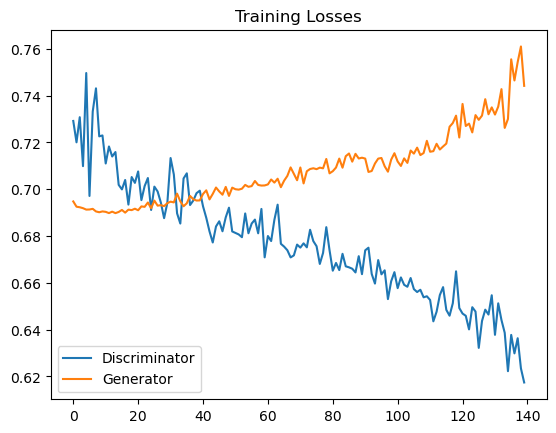

In [29]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [30]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [31]:
results

array([0.43069434, 0.53919297, 0.53919297, ..., 0.53919297, 0.36596254,
       0.53919297])

In [32]:
y2 = y_test.to_numpy()

In [33]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.4540187430597538
Mean score for Fall data : 0.5276370110665346


In [34]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [35]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5138888888888888
Precision : 0.7368421052631579
Recall : 0.01583710407239819
F1 : 0.031007751937984492


Confusion Matrix :


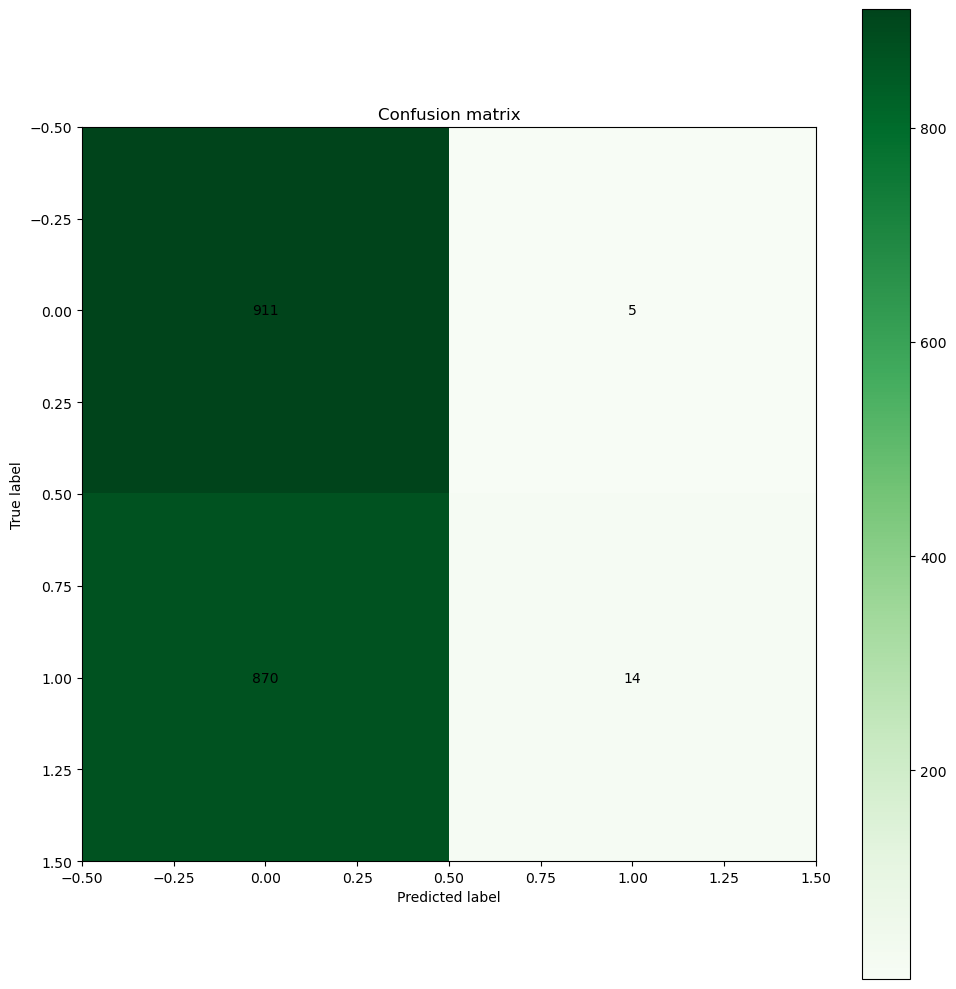

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:20<00:00, 41.81it/s]

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)